In [ ]:
!pip install tsplib95

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import random
import tsplib95
import networkx
import numpy as np
from matplotlib import pyplot as plt
from timeit import default_timer as timer

"""Plotting graphs"""



def draw_points(instance):
    x_cords = [i[0] for i in instance.node_coords.values()]
    y_cords = [i[1] for i in instance.node_coords.values()]
    labels = list(instance.node_coords.keys())

    # draw original points
    for x, y, label in zip(x_cords, y_cords, labels):
        plt.scatter(x, y, marker='o', color='green')
        # plt.text(x + 0.3, y + 0.3, label, fontsize=7)


def draw_path(a, b, instance):
    # draw result
    res_cords_x_a, res_cords_y_a = [instance.node_coords[i][0] for i in a], [instance.node_coords[i][1] for i in a]
    res_cords_x_b, res_cords_y_b = [instance.node_coords[i][0] for i in b], [instance.node_coords[i][1] for i in b]

    # print(res_cords)

    plt.plot(res_cords_x_a, res_cords_y_a, '-o')
    plt.plot(res_cords_x_b, res_cords_y_b, '-o')


"""Calculate cost"""


def vertex_to_dist_matrix(problem):
    return networkx.to_numpy_matrix(problem.get_graph())


def calc_cost(path, matrix):
    return np.sum([matrix[path[i] - 1, path[i + 1] - 1] for i in range(len(path) - 1)])


"""Nearest neighbour"""


def find_nearest_neighbor(vertex, matrix, visited_vertexes):
    distances = np.copy(matrix[vertex - 1, :])
    distances[:, [a - 1 for a in visited_vertexes]] = float('inf')
    result = np.argmin(distances) + 1

    return result


def find_new_path_by_neighbor(path, matrix, visited_vertexes):
    min_cost = float('inf')
    res_path = []

    for i in range(len(path)):
        neighbor = find_nearest_neighbor(path[i], matrix, visited_vertexes)

        # insert on left side
        new_path_left = path[:i] + [neighbor] + path[i:]

        cost_left = calc_cost(new_path_left, matrix)

        if cost_left < min_cost:
            res_path = new_path_left
            min_cost = cost_left

        # insert on right side
        new_path_right = path[:i + 1] + [neighbor] + path[i + 1:]

        cost_right = calc_cost(new_path_right, matrix)

        if cost_right < min_cost:
            res_path = new_path_right
            min_cost = cost_right

    return res_path


def nearest_neighbor_algorithm(matrix, a=None, b=None):
    if a is not None and b is not None:
        result_a, result_b = a[:-1], b[:-1]
    else:
        result_a, result_b = [[a] for a in random.sample(range(1, len(matrix) + 1), 2)]


    curr_set = 'a'
    while len(set(result_a)) + len(set(result_b)) < len(matrix):
        if curr_set == 'a':
            result_a = find_new_path_by_neighbor(result_a, matrix, result_a + result_b)
            curr_set = 'b'

        elif curr_set == 'b':
            result_b = find_new_path_by_neighbor(result_b, matrix, result_a + result_b)
            curr_set = 'a'

        # if not testing and len(result_a) % 10 == 0:
        #     draw_path(result_a, result_b, instance)

    result_a.append(result_a[0])
    result_b.append(result_b[0])

    return result_a, result_b


"""Additionl functions for steepest algotithm"""

def find_new_path_by_cycle_cost(path, matrix, visited_vertexes):
    min_cost = float('inf')
    res_path = []

    for i in range(0, len(path), 2):
        for neighbor in set(range(1, len(matrix) + 1)) - set(visited_vertexes):

            if random.randint(0,2): continue # OPTIMIZATION, TODO

            # print(neighbor)
            # insert on left side
            if i == 0:
                new_path_left = path[:i] + [neighbor] + path[i:]
                new_path_left[-1] = neighbor
            else:
                new_path_left = path[:i] + [neighbor] + path[i:]

            cost_left = calc_cost(new_path_left, matrix)

            if cost_left < min_cost:
                res_path = new_path_left
                min_cost = cost_left

            # insert on right side
            if i == len(path) - 1:
                new_path_right = path[:i + 1] + [neighbor] + path[i + 1:]
                new_path_right[0] = neighbor
            else:
                new_path_right = path[:i + 1] + [neighbor] + path[i + 1:]

            cost_right = calc_cost(new_path_right, matrix)

            if cost_right < min_cost:
                res_path = new_path_right
                min_cost = cost_right

    return res_path


def greedy_cycle_algorithm(matrix, a=None, b=None):

    # select starting vertexes
    if a is not None and b is not None:
        result_a, result_b = a, b
    else:
        result_a, result_b = [[a] for a in random.sample(range(1, len(matrix) + 1), 2)]

        # add second and third vertex to create a cycle
        result_a += [find_nearest_neighbor(result_a[0], matrix, result_a + result_b)]
        result_a.append(result_a[0])

        result_b += [find_nearest_neighbor(result_b[0], matrix, result_a + result_b)]
        result_b.append(result_b[0])

    curr_set = 'a'
    while len(set(result_a)) + len(set(result_b)) < len(matrix):

        if curr_set == 'a':
            result_a = find_new_path_by_cycle_cost(result_a, matrix, result_a + result_b)
            curr_set = 'b'

        elif curr_set == 'b':
            result_b = find_new_path_by_cycle_cost(result_b, matrix, result_a + result_b)
            curr_set = 'a'

    return result_a, result_b


def swap_edges(a, i, j):
    a_ = a.copy()
    a_[i:j] = a_[j - 1:i - 1:-1]

    if a_[0] != a[-1]:
        print(a)
        print(i, j)
        print(a_)
        raise AssertionError

    return a_


def swap_vertexes(a, b, i, j, single_path=False):


    if single_path:
        a_, b_ = np.copy(a), np.copy(b)

        a_[i], a_[j] = a_[j], a_[i]
        b_[i], b_[j] = b_[j], b_[i]

        if i == 0 or j == 0: a_[-1] = a_[0]
        if i == len(a) - 1 or j == len(a) - 1: a_[0] = a_[-1]
    else:
        old_a, old_b = a[i], b[j]

        a_ = [k if k!=old_a else old_b for k in a ]
        b_ = [k if k!=old_b else old_a for k in b ]

        # a_ = list(map(lambda x: x if x != a[i] else b[j], a_))
        # b_ = list(map(lambda x: x if x != b[j] else a[i], b_))

    return a_, b_


def calc_delta(a, b, i, j, matrix, mode):
    neigh_num = 1

    a_, b_ = a + a[1:], b + b[1:]
    i_, j_ = i + len(a) - 1, j + len(b) - 1

    if a[i] != a_[i_]:
        print(a[i])
        print(a_[i_])
        print(a)
        print(a_)
        print(i)
        print(i_)
        raise AssertionError

    if mode == "vertexes":
        frag_a, frag_b = a_[i_ - neigh_num:i_ + neigh_num + 1], b_[j_ - neigh_num:j_ + neigh_num + 1]

        cost_before = calc_cost(frag_a, matrix) + calc_cost(frag_b, matrix)

        frag_a, frag_b = swap_vertexes(frag_a, frag_b, len(frag_a)//2, len(frag_b)//2)

        cost_after = calc_cost(frag_a, matrix) + calc_cost( frag_b, matrix)

        return cost_before - cost_after

    elif mode == "edges":

        removed = matrix[a_[i_] - 1, a_[i_-1] - 1] + matrix[a_[j_] - 1, a_[j_-1] - 1]
        added = matrix[a_[i_-1] - 1, a_[j_-1] - 1] + matrix[a_[i_] - 1, b_[j_] - 1]

        return 2*(removed - added)

    else:
        raise AttributeError

    """

    a_next = i + 1 if i != len(a) - 1 else 2
    b_next = j + 1 if j != len(b) - 1 else 2

    a_before = i - 1 if i != 0 else len(a) - 2
    b_before = j - 1 if j != 0 else len(b) - 2

    if mode == "vertexes":

        if np.array_equiv(a, b) and (a_next == j or b_next == i):
            delta_a_gain = matrix[a[i] - 1, a[a_before] - 1] + matrix[a[i] - 1, a[a_next] - 1]
            delta_b_gain = matrix[b[j] - 1, b[b_next] - 1]

            delta_a_loss = matrix[a[i] - 1, b[b_before] - 1] + matrix[a[i] - 1, b[b_next] - 1]
            delta_b_loss = matrix[b[j] - 1, a[a_next] - 1]
        else:
            delta_a_gain = matrix[a[i] - 1, a[a_before] - 1] + matrix[a[i] - 1, a[a_next] - 1]
            delta_b_gain = matrix[b[j] - 1, b[b_before] - 1] + matrix[b[j] - 1, b[b_next] - 1]

            delta_a_loss = matrix[a[i] - 1, b[b_before] - 1] + matrix[a[i] - 1, b[b_next] - 1]
            delta_b_loss = matrix[b[j] - 1, a[a_before] - 1] + matrix[b[j] - 1, a[a_next] - 1]

    elif mode == "edges":
        delta_a_loss = matrix[a[a_before] - 1, b[b_before] - 1]
        delta_b_loss = matrix[a[i] - 1, b[j] - 1]

        delta_a_gain = matrix[a[a_before] - 1, a[i] - 1]
        delta_b_gain = matrix[b[b_before] - 1, b[j] - 1]

    else:
        raise NotImplementedError()

    return (delta_a_gain + delta_b_gain) - (delta_a_loss + delta_b_loss)
    """


def random_paths(set_size=200):
    l = [i for i in range(1, set_size + 1)]
    random.shuffle(l)

    p1, p2 = l[:set_size // 2], l[set_size // 2:]

    return p1 + [p1[0]], p2 + [p2[0]]


"""Steepest algorithm"""


def steepest_edges(matrix):  # mode: vertexes/edges, start_with: random, nn

    # random starting paths
    a, b = random_paths()
    res = []

    for source_path in (a, b):
        deltas = []  # to stop algorithm when it loops between two solutions
        while True:
            # find best swap
            best_swap, best_delta = None, None
            for i in range(1, len(source_path) - 2):
                # if random.randint(0,4)==0: continue
                for j in range(i + 1, len(source_path)):
                    # if random.randint(0,4)==0: continue
                    if i == j: continue
                    delta = calc_delta(source_path, source_path, i, j, matrix, mode="edges")
                    if best_delta is None or best_delta < delta:
                        best_delta = delta
                        best_swap = [i, j]
            deltas.append(best_delta)

            # print(calc_cost(source_path,matrix), (len(set(deltas[-30:]))))
            if best_delta <= 0 or (len(set(deltas[-30:])) <= 3 and len(deltas) > 120):
                res.append(source_path)
                break
            # draw_path(source_path,[],tsplib95.load(instance_filename))
            source_path = swap_edges(source_path, *best_swap)

    return res[0], res[1]


def get_adjacent_vertexes(path,vert):

    path_ = path + path[1:]

    idx = path_.index(vert, len(path)-1)

    return [path_[idx - 1], path_[idx + 1]]



def steepest_edges_with_list(matrix, candidates_mode=False, n_neighbors=10, a=None, b=None):
    LM = []  # list of moves

    if a is None and b is None:
        a, b = random_paths()  # starting paths

    performed_moves = []

    last_changes = None

    candidates_dist = candidates_dist_dict(matrix)

    init = True


    while True:

        # scanning NEW moves
        new_moves = get_new_available_moves(a, b, LM, matrix, last_changes, init, candidates_mode, n_neighbors, candidates_dist)

        init = False

        moves_after_changes = new_moves.copy()

        found_move = False

        for i, mov in enumerate(new_moves):
            # print(i)

            applicable = is_applicable(mov, a, b)

            if applicable is False:  # Usuwane krawędzie nie występują już w bieżącym rozwiązaniu
                moves_after_changes[i] = None

            elif applicable == "reverse":  # Usuwane krawędzie występują w bieżącym rozwiązaniu w różnym od zapamiętanego kierunku – może być aplikowalny w przyszłości
                continue

            elif applicable is True:  # Usuwane krawędzie występują w bieżącym rozwiązaniu w tym samym kierunku (także obie odrócone)

                affected_vertexes = get_adjacent_vertexes(a, mov.ver_a) if mov.ver_a in a else get_adjacent_vertexes(b, mov.ver_a)
                affected_vertexes += get_adjacent_vertexes(b, mov.ver_b) if mov.ver_b in b else get_adjacent_vertexes(a, mov.ver_b)

                last_changes = [mov, affected_vertexes]

                # if [a, b] == perform_move(mov, a, b):
                #    raise AssertionError

                a, b = perform_move(mov, a, b)


                performed_moves.append((mov.ver_a, mov.ver_b,mov.mode))

                # print(f"curr_cost={calc_cost(a, matrix) + calc_cost(b, matrix)}, avail_options size = {len(new_moves)}, did move {vars(mov)}")

                # draw_path(a, b, instance)

                found_move = True

                """
                if a[0] != a[-1] or b[0] != b[-1]:
                    print(a)
                    print(b)
                    raise AssertionError
                """



                moves_after_changes[i] = None

                if i < len(moves_after_changes) - 1:
                    if {moves_after_changes[i + 1].ver_a, moves_after_changes[i + 1].ver_b} == {mov.ver_a,
                                                                                                mov.ver_b} and \
                            moves_after_changes[i + 1].mode == mov.mode == 'vertexes':
                        moves_after_changes[i + 1] = None

                LM = [a for a in moves_after_changes if a is not None]

                break

            else:
                return NotImplementedError

        if not found_move or (len(set(performed_moves[-30:])) <= 3 and len(performed_moves) > 120):
            return a, b


"""Find new moves"""


class Move:
    def __init__(self, ver_a, ver_b, mode, delta, path_name, edges_to_swap):
        self.ver_a = ver_a
        self.ver_b = ver_b
        self.edges_to_swap = edges_to_swap
        self.mode = mode
        self.delta = delta
        self.path_name = path_name


def perform_move(move, a, b):
    if move.mode == "vertexes":

        return swap_vertexes(a, b, a.index(move.ver_a), b.index(move.ver_b)) if (move.ver_a in a) else swap_vertexes(a, b, a.index(move.ver_b), b.index(move.ver_a))

    elif move.mode == "edges":

        if move.path_name == 'a':
            return swap_edges(a, a.index(move.ver_a), a.index(move.ver_b)), b
        else:
            return a, swap_edges(b, b.index(move.ver_a), b.index(move.ver_b))

    else:
        raise NotImplementedError


def move_delta_update_or_append(move, lst):
    """
    for i, a in enumerate(lst):
        if move.mode == a.mode == 'vertexes' and {move.ver_a, move.ver_b} == {a.ver_a, a.ver_b}:
            lst[i].delta = move.delta
            return

        elif move.mode == a.mode == 'edges' and set(move.edges_to_swap) == set(a.edges_to_swap):
            lst[i].delta = move.delta
            return
    """
    lst.append(move)


def candidates_dist_dict(matrix):

    candidates = {}

    for i in range(1, len(matrix)+1):

        costs = []

        for j in range(1, len(matrix)+1):

            if i != j: costs.append([j, matrix[i-1, j-1]])

        costs.sort(key=lambda x: x[1])

        candidates[i] = [c[0] for c in costs]

    return candidates

def find_candidates(path, candidates_distances, n=10):

    candidates = {}

    for v in path:
        candidates[v] = candidates_distances[v][0:n]

    return candidates.items()



DELTA_ADD_THRESHOLD = 1


def get_new_available_moves(a, b, moves, matrix, last_changes, init=False, candidates_mode=False, n_neighbors=10,candidates_dist = None):

    if not candidates_mode:

        avail_moves = moves.copy()

        a_idxs, b_idxs = [], []

        if not init:
            for v in [last_changes[0].ver_a, last_changes[0].ver_b, *last_changes[1]]:
                if v in a:
                    a_idxs.append(a.index(v))
                elif v in b:
                    b_idxs.append(b.index(v))
                else:
                    raise AssertionError

        # swapping-edges moves
        if init:
            for path, path_name in zip([a, b], ['a', 'b']):
                for i in range(1, len(path) - 2):
                    for j in range(i + 1, len(path) - 1):
                        move = Move(path[i], path[j], 'edges', calc_delta(path, path, i, j, matrix, mode="edges"),
                                    path_name, path[i:j + 1])
                        if move.delta > DELTA_ADD_THRESHOLD: avail_moves.append(move)
        elif last_changes[0].mode == "edges":
            for path, path_name, idxs in zip([a, b], ['a', 'b'], [a_idxs, b_idxs]):
                for idx in idxs:
                    if idx == 0 or idx >= len(path) - 1: continue

                    possibs = []

                    for j in range(idx + 1, len(path) - 1): possibs.append([idx, j])
                    for j in range(1, idx - 1): possibs.append([j, idx])

                    for i, j in possibs:
                        if i == j: continue
                        move = Move(path[i], path[j], 'edges', calc_delta(path, path, i, j, matrix, mode="edges"),
                                    path_name, edges_to_swap=path[i:j + 1])

                        if move.delta > DELTA_ADD_THRESHOLD:   # if delta>0
                            move_delta_update_or_append(move, avail_moves)
        """
        if init:
            # swapping-vertexes moves
    
            for i in range(len(a)):
                for j in range(len(b)):
                    if i==j: continue
                    move = Move(a[i], b[j], 'vertexes', calc_delta(a, b, i, j, matrix, mode="vertexes"), None, None)
                    if move.delta > DELTA_ADD_THRESHOLD: avail_moves.append(move)
        
        elif last_changes[0].mode == "vertexes":
            for idxs, own_set, opposite_set in zip([a_idxs, b_idxs], [a,b], [b, a]):
                for i in idxs:
                    for j in range(len(opposite_set)):
                        if opposite_set[j] in [last_changes[0].ver_a, last_changes[0].ver_b]: continue
                        move = Move(own_set[i], opposite_set[j], 'vertexes', calc_delta(own_set, opposite_set, i, j, matrix, mode="vertexes"), None, None)
                        if move.delta > DELTA_ADD_THRESHOLD:
                            move_delta_update_or_append(move, avail_moves)
        """
    else:

        if not init and random.randint(0,3)!=0: return moves # TODO

        avail_moves = []

        for path, opposite_path, path_name in zip([a,b], [b,a], ['a','b']):  # dla każdej ścieżki
            for v, candidates in find_candidates(path, candidates_dist, n_neighbors):  # iteruj po wierzchołkach ścieżki
                for candidate in candidates:                        # i najbliższym temu wierzchołkowi kandydatach

                    if candidate in path:       # jesli wierzchołek i kandydat są w tej samej ścieżce
                        i, j = path.index(v), path.index(candidate)
                        # wymień krawędzie

                        if v == candidate:
                            print(v)
                            print(candidates)
                            raise AssertionError

                        if i == 0 or j == 0 or i >= len(path) - 1 or j >= len(path): continue

                        move = Move(path[i], path[j], 'edges', calc_delta(path, path, i, j, matrix, mode="edges"),
                                    path_name, edges_to_swap=path[i:j + 1])

                        if move.delta > DELTA_ADD_THRESHOLD:  # if delta>0
                            avail_moves.append(move)

                    else:
                        # wymiana wierzchołków

                        i, j = path.index(v), opposite_path.index(candidate)

                        move = Move(path[i], opposite_path[j], 'vertexes', calc_delta(path, opposite_path, i, j, matrix, mode="vertexes"), None, None)
                        if move.delta > DELTA_ADD_THRESHOLD:
                            move_delta_update_or_append(move, avail_moves)

    avail_moves.sort(key=lambda x: x.delta, reverse=True)

    return avail_moves


def is_subpath(path, subpath):  # sprawdzanie czy podsciezka subpath znajduje sie w ścieżce path
    path_ = path + path[1:]  # for path is a cycle

    for i in range(len(path_)):
        if path_[i:i + len(subpath)] == subpath: return True

    return False


def is_applicable(move, a, b):
    if move.mode == 'vertexes':

        if move.ver_a in a and move.ver_b in b or move.ver_a in b and move.ver_b in a:
            return True
        else:
            return False

    elif move.mode == 'edges':
        path = a if move.path_name == 'a' else b

        if not is_subpath(path, move.edges_to_swap):
            return False
        elif is_subpath(path, move.edges_to_swap[::-1]):
            return "reverse"
        elif is_subpath(path, move.edges_to_swap):
            return True
        else:
            return AttributeError

    else:
        raise AttributeError

"""ILS2 (Large-scale neighborhood search, Destroy-Repair)"""

def find_new_path_by_regret_cost(path, matrix, visited_vertexes):
    min_cost = float('inf')
    res_path = []
    old_regret, regret, regret_min = 0, 0, 0
    cost = []
    for neighbor in set(range(1, len(matrix) + 1)) - set(visited_vertexes):
        dict = {}
        for i in range(0, len(path)):

            if i == 0:
                new_path_left = path[:i] + [neighbor] + path[i:]
                new_path_left[-1] = neighbor
            else:
                new_path_left = path[:i] + [neighbor] + path[i:]
            cost_left = calc_cost(new_path_left, matrix)
            if cost_left < min_cost:
                new_path = new_path_left
                min_cost = cost_left
            dict[cost_left] = new_path_left
        cost.append(dict)
    for i in range(len(path)):
        neighbor = find_nearest_neighbor(path[i], matrix, visited_vertexes)

        new_path_left = path[:i] + [neighbor] + path[i:]
        cost_left = calc_cost(new_path_left, matrix)

        if cost_left < min_cost:
            res_path = new_path_left
            min_cost = cost_left

        new_path_right = path[:i + 1] + [neighbor] + path[i + 1:]
        cost_right = calc_cost(new_path_right, matrix)

        if cost_right < min_cost:
            res_path = new_path_right
            min_cost = cost_right
    for c in cost:
        if len(c) > 0: regret_min = sorted(c.keys())[0]
        if len(c) > 1:
            regret = sorted(c.keys())[1] - sorted(c.keys())[0]
            if regret > old_regret:
                old_regret = regret
                res_path = c[sorted(c.keys())[0]]
    if regret_min * 0.7 > min_cost or (regret_min - 2 * regret) > min_cost:
        res_path = new_path
    return res_path


def greedy_2_regret_algorithm(matrix, a=None, b=None):

    if a is not None and b is not None:
        result_a, result_b = a, b
    else:
        # select starting vertexes
        result_a, result_b = [[a] for a in random.sample(range(1, len(matrix) + 1), 2)]
        # add second and third vertex to create a cycle
        result_a += [find_nearest_neighbor(result_a[0], matrix, result_a + result_b)]
        result_a.append(result_a[0])

        result_b += [find_nearest_neighbor(result_b[0], matrix, result_a + result_b)]
        result_b.append(result_b[0])


    curr_set = 'a'
    while len(set(result_a)) + len(set(result_b)) < len(matrix):
        if curr_set == 'a':
            result_a = find_new_path_by_regret_cost(result_a, matrix, result_a + result_b)
            curr_set = 'b'

        elif curr_set == 'b':
            result_b = find_new_path_by_regret_cost(result_b, matrix, result_a + result_b)
            curr_set = 'a'


    return result_a, result_b


def delete_random_elements(a, b, matrix, coef=0.2, near_borders=True):

    a_, b_ = a.copy(), b.copy()

    if near_borders:
        weights = {'a': {}, 'b': {}}

        for path, opposite_path, path_name in zip([a_, b_], [b_, a_], ['a','b']):
            for v in path: weights[path_name][v] = min([matrix[v-1,i-1] for i in opposite_path])

    while len(a_) + len(b_) > (1-coef) * (len(a) + len(b)):
        if near_borders:
            for path, opposite_path, path_name in zip([a_, b_], [b_, a_], ['a', 'b']):
                weights_sorted = list(weights[path_name].items())
                weights_sorted = list(filter(lambda x: x[0] not in (path[0], path[-1]), weights_sorted ))
                weights_sorted.sort(key=lambda x: x[1])

                elem_to_delete = weights_sorted[0][0]

                if path_name == 'a':
                    a_.remove(elem_to_delete)
                    del weights[path_name][elem_to_delete]
                else:
                    b_.remove(elem_to_delete)
                    del weights[path_name][elem_to_delete]

        else:
            idx_a, idx_b = random.randint(1,len(a_)-2), random.randint(1, len(b_)-2)

            del a_[idx_a]
            del b_[idx_b]

        assert a_[0]==a_[-1] and b_[0]==b_[-1]

    return a_, b_

def msls(matrix):
    a, b = random_paths()

    for _ in range(100):
        a, b = steepest_edges_with_list(matrix, True, 10, a, b)

    return a, b


from numpy import roll

def ils2(matrix, with_local=False, probab = 0.1, coef=0.7, n_neigh=13, near_borders=True):

    # starting solution
    # a, b = steepest_edges_with_list(matrix, candidates_mode=True, n_neighbors=n_neigh)

    a = [43, 178, 56, 148, 88, 39, 130, 72, 83, 62, 54, 187, 6, 109, 107, 157, 120, 47, 31, 67, 65, 177, 13, 79, 160, 15,
     123, 198, 27, 191, 145, 85, 132, 1, 53, 115, 117, 111, 46, 172, 121, 174, 159, 24, 32, 136, 61, 26, 199, 138, 78,
     82, 9, 124, 118, 16, 63, 188, 51, 194, 122, 116, 44, 66, 153, 48, 84, 119, 19, 99, 92, 10, 175, 97, 81, 33, 100,
     156, 180, 131, 189, 142, 69, 108, 101, 60, 167, 23, 173, 144, 150, 91, 94, 95, 168, 185, 50, 139, 86, 137, 43]
    b = [154, 73, 3, 59, 41, 89, 30, 68, 169, 35, 2, 181, 125, 161, 151, 80, 77, 158, 128, 193, 147, 40, 12, 93, 190, 149,
     106, 163, 4, 192, 14, 74, 57, 36, 45, 197, 104, 165, 126, 87, 96, 166, 52, 11, 170, 179, 7, 37, 184, 29, 110, 18,
     49, 162, 20, 64, 55, 135, 42, 186, 127, 112, 75, 155, 183, 8, 22, 134, 129, 146, 143, 17, 25, 90, 34, 103, 114, 98,
     58, 141, 171, 200, 28, 38, 71, 152, 196, 5, 105, 133, 176, 113, 195, 182, 76, 70, 102, 164, 140, 21, 154]

    start = timer()

    while timer()-start < 45: # TODO

        # deleting random elements (edges/vertexes)
        a_, b_ = delete_random_elements(a, b, matrix, coef=coef, near_borders=near_borders)

        # przesunięcie (shift) ścieżki żeby poprawić jakość rozwiązań algorytmu NN
        # to nie zmienia nic w strukturze ścieżki ani jej jakości
        a_, b_ = list(roll(a_[:-1], random.randint(1, len(a_)))), list(roll(b_[:-1], random.randint(1, len(b_))))
        a_ += [a_[0]]
        b_ += [b_[0]]

        # repairing
        if random.random() > probab: a_, b_ = nearest_neighbor_algorithm(matrix, a_, b_)
        else: a_, b_ = greedy_cycle_algorithm(matrix, a_, b_)
        # a_, b_ = greedy_2_regret_algorithm(matrix, a_, b_)

        if with_local:
            a_, b_ = steepest_edges_with_list(matrix, True, n_neigh, a_, b_)

        old_cost, curr_cost = calc_cost(a, matrix)+calc_cost(b, matrix), calc_cost(a_, matrix)+ calc_cost(b_,matrix)

        if old_cost > curr_cost:
            a, b = a_, b_
            # print(curr_cost)
        else:
            pass
            # print(".", end="")


    # draw_path(a,b,inst)
    #plt.title(calc_cost(a,matrix)+calc_cost(b,matrix))
    #plt.show()
    return a, b


    """
    if from_random:
        a, b = random_paths()
    else:
        a, b = steepest_edges_with_list(dist, candidates_mode=True, n_neighbors=10)
    """

"""
inst = tsplib95.load('kroA200.tsp')
dist = vertex_to_dist_matrix(inst)
ils2(dist)
exit()
"""

"""Perform test"""




'Perform test'

In [ ]:
from time import time
def ils1(matrix, local_alg,time_limit=10):# with_local=True,time_limit=10):
    start = time()
    a,b = local_alg(matrix,candidates_mode=False, n_neighbors=10) #lokalne przeszukiwanie
    best_score = calc_cost(a,matrix)+calc_cost(b,matrix)
    while time()-start < time_limit: #TODO
        a_,b_ = np.copy(a),np.copy(b)
        a_,b_ = perturbation(matrix, a_,b_)
        a_,b_ = local_alg(matrix,candidates_mode=False, n_neighbors=10, a=a_,b=b_) #lokalne przeszukiwanie
        new_score = calc_cost(a_,matrix)+calc_cost(b_,matrix)
        if new_score < best_score:
            a,b = np.copy(a_),np.copy(b_)
            best_score = new_score
    return a,b
def perturbation(matrix, a,b,n=20):
    candidates = [(i, j) for i in range(len(a)) for j in range(len(b))]
    old_cost=calc_cost(a, matrix) +calc_cost( b, matrix)
    a_,b_=np.copy(a),np.copy(b)
    for move in range(n):
        random.shuffle(candidates)
        r=0 #random.sample(range(2), 2)
        if r==0: 
          for i, j in candidates:
            a_,b_ =swap_vertexes(a,b, i , j)
            new_cost=calc_cost(a_, matrix) + calc_cost( b_, matrix)
            if (old_cost-new_cost)<0:
                old_cost=new_cost
                delta=(i,j),0
                a,b=np.copy(a_),np.copy(b_)
        else: 
            for i,j in candidates:
              c=random.sample(range(2), 2)
              if c==0: a_=swap_edges(a, i, j)
              else: b_=swap_edges(b, i, j)
              new_cost=calc_cost(a_, matrix) + calc_cost( b_, matrix)
              if (old_cost-new_cost)<0:
                  old_cost=new_cost
                  delta=(i,j),0
                  a,b=np.copy(a_),np.copy(b_)
    return a,b

In [ ]:
start_pop=[(greedy_2_regret_algorithm(dist_matrix)) for i in range(5)]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


22 22
37 37
13 13


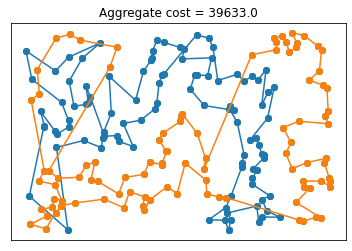

In [ ]:
from IPython.display import clear_output
from time import sleep,time
from tqdm import tqdm
from copy import deepcopy
import numpy as np
from operator import itemgetter
"""
Wygeneruj populację początkową X
powtarzaj
Wylosuj dwa różne rozwiązania (rodziców) stosując rozkład równomierny 
Skonstruuj rozwiązanie potomne y poprzez rekombinację rodziców
y := Lokalne przeszukiwanie (y)
jeżeli y jest lepsze od najgorszego rozwiązania w populacji i (wystarczająco) różne od wszystkich 
rozwiązań w populacji
Dodaj y do populacji i usuń najgorsze rozwiązanie
dopóki nie są spełnione warunki stopu
"""
def combine(a1,b1,a2,b2,matrix):
    a_1,a_2,b_1,b_2=np.copy(a1),np.copy(a2),np.copy(b1),np.copy(b2)
    rest=[]
    a,b=[],[]
    l=len(a_2)
    start,stop=random.randint(0,l),random.randint(0,l)
    if start>stop:
      start,stop=stop,start
      a=list(a_1[start:stop])
      b=list(b_1[start:stop])
    elif stop>start:
      a=list(a_1[start:stop])
      b=list(b_1[start:stop])
    else:
      a=a_1
      b=b_1
    a_=[]
    b_=[]
    for s in range(l-1):
      if [a_2[s],a_2[s+1]] in a_1:
        pass


    """
    for s in range(l):
      if a_2[s] not in a and a_2[s] not in b:
        a_.append(a_2[s])
    for s in range(len(b_2)):
      if b_2[s] not in a and b_2[s] not in b:
        b_.append(b_2[s])
    add_=a_+b_
    len_a=len(a)
    a=list(add_[:start])+list(a)+list(add_[start:])[:l]
    a=a[:100]
    add_=add_[l-len_a:]
    a.append(a[0])
    b=list(add_[:start])+list(b)+list(add_[start:])
    b=b[:100]
    b.append(b[0])
    """
    return a,b, calc_cost(a,matrix)+calc_cost(b,matrix)
def combine2(a1,b1,a2,b2,matrix):
    a_1,a_2,b_1,b_2=np.copy(a1),np.copy(a2),np.copy(b1),np.copy(b2)
    rest=[]
    a,b=[],[]
    for cyc1 in (a_1,b_1):
      l=len(cyc1)
      print(l)
      if l==1:
        continue
      for j in range(len(cyc1)):
        p, q = cyc1[j], cyc1[(j+1)%l]
        if p == -1 or q == -1 or p == q:
          continue
        found = False
        for cyc2 in (a_2,b_2):
            m = len(cyc2)
            for i in range(m):
                u, v = cyc2[i], cyc2[(i+1)%m]
                if (p == u and q == v) or (p == v and q == u):
                    found = True
                    break
            if found:
              break
        if not found:
            rest.append(cyc1[j])
            rest.append(cyc1[(j+1)%l])
            cyc1[j] = -1
            cyc1[(j+1)%l] = -1
      for i in range(1, l):
        x, y, z = cyc1[(j-1)%l], cyc1[j], cyc1[(j+1)%l]
        if x == z == -1 and y != -1:
            rest.append(y)
            cyc1[j] = -1
      for i in range(1, n):
        x = cyc1[j]
        if x != -1 and np.random.rand() < 0.2:
            rest.append(x)
            cyc1[j] = -1
      
      a = [x for x in a_1 if x != -1]
      b = [x for x in b_1 if x != -1]
      assert len(a) + len(b) + len(rest) == 200
      return solve_regret_init(matrix, (a, b), rest)[1]
                
      return a,b, calc_cost(a,matrix)+calc_cost(b,matrix)
def identity(x):
    return x


def get_max(x, f=identity):
    return max(np.arange(len(x)), key=lambda i: f(x[i]))

def get_min(x, f=identity):
    return min(np.arange(len(x)), key=lambda i: f(x[i]))


def HAE(matrix,time_limit=2,local=True,patience=300):
    a, b = random_paths()
    start_pop=[(greedy_2_regret_algorithm(matrix)) for i in range(5)]
    start_population=[(a,b,calc_cost(a,matrix)+calc_cost(b,matrix)) for a,b in start_pop]
    best_scores,worst_scores=[],[]
    count,min_diff,last_improv=0,0,0
    start=time()
    while (time()-start) <5:
        count+=1
        pop_idx = np.arange(len(start_population))
        np.random.shuffle(pop_idx)
        

        a1, b1, score1 = start_population[pop_idx[0]]
        a2, b2, score2 = start_population[pop_idx[1]]
        #worst solution
        worst_a,worst_b, worst_score = max(start_population, key=itemgetter(2))
        new_a, new_b,new_score = combine(a1,b1,a2,b2,matrix)
        print(len(new_a),len(new_b))
        if local:
            a2, b2 =greedy_2_regret_algorithm(matrix, new_a,new_b)
            new_score =calc_cost(a,matrix)+calc_cost(b,matrix)
        #if new_score<curr_best:  pass
        if new_score<worst_score and not any(abs(new_score - s) < min_diff for _,_, s in start_population):
            start_population[get_max(start_population, lambda x: x[2])]=new_a,new_b,new_score
            last_improv= count
        
        best_idx = get_min(start_population, lambda x: x[2])
        best_a,best_b, best_score = start_population[best_idx]
        best_scores.append(best_score)
        worst_scores.append(worst_score)
        if count - last_improv > patience:
                break
    return best_a,best_b


instance = tsplib95.load('kroB200.tsp')
dist_matrix = vertex_to_dist_matrix(instance)

for i in range(3):
  a, b = HAE(dist_matrix, instance)
  #cost = calc_cost(a, dist_matrix) + calc_cost(b, dist_matrix)
  save_plot(a, b, "out"+str(i)+".png")
# save_plot(a, b, "out.png")


In [ ]:
NUM_OF_ITERATIONS = 10


def perform_test(instance_filenames):
    for instance_filename in instance_filenames:

        inst = tsplib95.load(instance_filename)
        dist = vertex_to_dist_matrix(inst)

        for algorithm in ("ils1", 'ils2T','ils2F','msls'): # msls, ils2

                results, time_results = [], []

                for i in range(NUM_OF_ITERATIONS):
                    ts = timer()

                    # if int(i * 100 / NUM_OF_ITERATIONS)%10==0: print(f"{int(i * 100 / NUM_OF_ITERATIONS)}, ", end="")
                    # print(f"{int(i * 100 / NUM_OF_ITERATIONS)}, ", end="")

                    if algorithm == 'ils2T': res_a, res_b = ils2(dist, with_local = True)
                    elif algorithm == 'ils2F': res_a, res_b = ils2(dist, with_local = False)
                    elif algorithm == 'ils1': res_a, res_b = ils2(dist,steepest_edges_with_list,)
                    elif algorithm == 'msls': res_a, res_b = msls(dist)
                    else: raise AssertionError

                    time_results.append(timer() - ts)

                    print(f"{int(i * 100 / NUM_OF_ITERATIONS)} - {calc_cost(res_a, dist) + calc_cost(res_b, dist)}", end=", ")

                    results.append((calc_cost(res_a, dist) + calc_cost(res_b, dist), res_a, res_b))  # sum of costs of a and b, start_a, start_b


                maxi = max(results, key=lambda item: item[0])
                mini = min(results, key=lambda item: item[0])

                # print(f"{start}, {method}, {instance_filename}, {version} min={mini[0]}, maxi={maxi[0]}, avg={sum([a[0] for a in results]) / len(results)}, avg_time={(te - ts)/NUM_OF_ITERATIONS}")

                print(
                    f" {instance_filename}, {algorithm},  | {int(sum([a[0] for a in results]) / len(results))} ({int(mini[0])} - {int(maxi[0])}), {round(sum(time_results) / len(time_results), 3)} ({round(min(time_results), 3)} - {round(max(time_results), 3)})")


                # save best result to file
                plt.clf()
                plt.gca().get_xaxis().set_visible(False)
                plt.gca().get_yaxis().set_visible(False)
                draw_points(inst)
                draw_path(mini[1], mini[2], inst)
                plt.title(f"Aggregate cost = {mini[0]}")
                plt.savefig(f"{instance_filename.replace('/', '-')}_{algorithm}_.png")

                if algorithm == "msls": break  # TODO

def save_plot(a, b, filename):
    # save result to file
    plt.clf()
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)
    draw_points(instance)
    draw_path(a, b, instance)
    plt.title(f"Aggregate cost = {calc_cost(a, dist_matrix) + calc_cost(b, dist_matrix)}")
    plt.savefig(filename)


testing = False

if testing:
    perform_test(instance_filenames=['kroA200.tsp', 'kroB200.tsp'])

elif testing:
    # load instance
    instance = tsplib95.load('kroA100.tsp')
    dist_matrix = vertex_to_dist_matrix(instance)
    mini = 1000000
    while True:
        a, b = nearest_neighbor_algorithm(dist_matrix, instance)
        cost = calc_cost(a, dist_matrix) + calc_cost(b, dist_matrix)
        if cost < mini:
            print(cost, a, b)
            mini = cost
            save_plot(a, b, "out.png")

    # save_plot(a, b, "out.png")